In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from keras.utils.np_utils import to_categorical
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split, GroupShuffleSplit, GroupKFold
import os

In [2]:
disease_types=['COVID', 'non-COVID']
data_dir = '../input/sarscov2-ctscan-dataset/'
train_dir = os.path.join(data_dir)

In [3]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])      
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])

In [4]:
IMAGE_SIZE = 64
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) 
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [5]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
X_Train = X_train / 255.
print(X_Train.shape)

2481it [00:18, 132.76it/s]


(2481, 64, 64, 3)


In [6]:
Y_train = train['DiseaseID'].values
Y_train.shape

(2481,)

In [7]:
Y_train = to_categorical(Y_train, num_classes=2)
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.1)

In [8]:
from keras.layers import  Flatten, Dense, Dropout
from keras.applications import VGG16
from keras.models import Model
from keras import optimizers
from keras.optimizers import Adam
from keras.layers import Dense, GlobalAveragePooling2D
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
vgg16_model = VGG16(weights = 'imagenet', include_top = False,input_shape=(150,150,3))
x = vgg16_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

predictions = Dense(2, activation = 'softmax')(x)
model = Model(vgg16_model.input,predictions)
for layer in vgg16_model.layers:
    layer.trainable = False
optimizer = Adam(lr=0.0002)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_______________________________________________________

In [9]:
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

In [10]:
training_datagen = ImageDataGenerator(rotation_range=40, 
                        width_shift_range=0.2, 
                        height_shift_range=0.2, 
                        zoom_range=0.2, 
                        horizontal_flip=True, 
                        vertical_flip=True,
                        shear_range=0.2) 

train_generator = training_datagen.flow(X_train, Y_train,batch_size=64)
training_datagen.fit(X_train)
from keras import callbacks

filepath="Best1.hdf5"
checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_loss',save_best_only=True, mode='min',verbose=1)
callbacks_list = [checkpoint]

history = model.fit_generator(train_generator, steps_per_epoch=35, epochs=200,
                              validation_data=(X_val, Y_val),validation_steps=50,callbacks=callbacks_list)

Epoch 1/200
35/35 [==============================] - ETA: 0s - loss: 1.0778 - accuracy: 0.5547
Epoch 00001: val_loss improved from inf to 0.65636, saving model to Best1.hdf5
35/35 [==============================] - 4s 110ms/step - loss: 1.0778 - accuracy: 0.5547 - val_loss: 0.6564 - val_accuracy: 0.5984
Epoch 2/200
35/35 [==============================] - ETA: 0s - loss: 0.9601 - accuracy: 0.6241
Epoch 00002: val_loss did not improve from 0.65636
35/35 [==============================] - 3s 87ms/step - loss: 0.9601 - accuracy: 0.6241 - val_loss: 0.6660 - val_accuracy: 0.6024
Epoch 3/200
35/35 [==============================] - ETA: 0s - loss: 0.8721 - accuracy: 0.6510
Epoch 00003: val_loss did not improve from 0.65636
35/35 [==============================] - 3s 95ms/step - loss: 0.8721 - accuracy: 0.6510 - val_loss: 0.6824 - val_accuracy: 0.6104
Epoch 4/200
35/35 [==============================] - ETA: 0s - loss: 0.8576 - accuracy: 0.6478
Epoch 00004: val_loss did not improve from 0.656

Epoch 30/200
35/35 [==============================] - ETA: 0s - loss: 0.6017 - accuracy: 0.7101
Epoch 00030: val_loss did not improve from 0.47877
35/35 [==============================] - 3s 87ms/step - loss: 0.6017 - accuracy: 0.7101 - val_loss: 0.4874 - val_accuracy: 0.7791
Epoch 31/200
35/35 [==============================] - ETA: 0s - loss: 0.5881 - accuracy: 0.7043
Epoch 00031: val_loss did not improve from 0.47877
35/35 [==============================] - 4s 104ms/step - loss: 0.5881 - accuracy: 0.7043 - val_loss: 0.4885 - val_accuracy: 0.7751
Epoch 32/200
35/35 [==============================] - ETA: 0s - loss: 0.6156 - accuracy: 0.6900
Epoch 00032: val_loss did not improve from 0.47877
35/35 [==============================] - 3s 86ms/step - loss: 0.6156 - accuracy: 0.6900 - val_loss: 0.4822 - val_accuracy: 0.7791
Epoch 33/200
35/35 [==============================] - ETA: 0s - loss: 0.5728 - accuracy: 0.7088
Epoch 00033: val_loss did not improve from 0.47877
35/35 [==============

Epoch 60/200
35/35 [==============================] - ETA: 0s - loss: 0.5357 - accuracy: 0.7397
Epoch 00060: val_loss did not improve from 0.47877
35/35 [==============================] - 4s 102ms/step - loss: 0.5357 - accuracy: 0.7397 - val_loss: 0.5110 - val_accuracy: 0.7550
Epoch 61/200
35/35 [==============================] - ETA: 0s - loss: 0.5299 - accuracy: 0.7392
Epoch 00061: val_loss did not improve from 0.47877
35/35 [==============================] - 3s 88ms/step - loss: 0.5299 - accuracy: 0.7392 - val_loss: 0.5049 - val_accuracy: 0.7631
Epoch 62/200
35/35 [==============================] - ETA: 0s - loss: 0.5302 - accuracy: 0.7334
Epoch 00062: val_loss did not improve from 0.47877
35/35 [==============================] - 4s 103ms/step - loss: 0.5302 - accuracy: 0.7334 - val_loss: 0.5008 - val_accuracy: 0.7671
Epoch 63/200
35/35 [==============================] - ETA: 0s - loss: 0.5200 - accuracy: 0.7446
Epoch 00063: val_loss did not improve from 0.47877
35/35 [=============

Epoch 90/200
35/35 [==============================] - ETA: 0s - loss: 0.5154 - accuracy: 0.7384
Epoch 00090: val_loss did not improve from 0.47877
35/35 [==============================] - 3s 88ms/step - loss: 0.5154 - accuracy: 0.7384 - val_loss: 0.4916 - val_accuracy: 0.7631
Epoch 91/200
35/35 [==============================] - ETA: 0s - loss: 0.5208 - accuracy: 0.7428
Epoch 00091: val_loss did not improve from 0.47877
35/35 [==============================] - 3s 88ms/step - loss: 0.5208 - accuracy: 0.7428 - val_loss: 0.4996 - val_accuracy: 0.7590
Epoch 92/200
35/35 [==============================] - ETA: 0s - loss: 0.5106 - accuracy: 0.7379
Epoch 00092: val_loss did not improve from 0.47877
35/35 [==============================] - 3s 93ms/step - loss: 0.5106 - accuracy: 0.7379 - val_loss: 0.5025 - val_accuracy: 0.7550
Epoch 93/200
35/35 [==============================] - ETA: 0s - loss: 0.5330 - accuracy: 0.7321
Epoch 00093: val_loss did not improve from 0.47877
35/35 [===============

Epoch 120/200
35/35 [==============================] - ETA: 0s - loss: 0.5095 - accuracy: 0.7410
Epoch 00120: val_loss did not improve from 0.47877
35/35 [==============================] - 3s 89ms/step - loss: 0.5095 - accuracy: 0.7410 - val_loss: 0.5243 - val_accuracy: 0.7349
Epoch 121/200
35/35 [==============================] - ETA: 0s - loss: 0.4974 - accuracy: 0.7518
Epoch 00121: val_loss did not improve from 0.47877
35/35 [==============================] - 3s 99ms/step - loss: 0.4974 - accuracy: 0.7518 - val_loss: 0.5342 - val_accuracy: 0.7229
Epoch 122/200
35/35 [==============================] - ETA: 0s - loss: 0.5109 - accuracy: 0.7455
Epoch 00122: val_loss did not improve from 0.47877
35/35 [==============================] - 3s 91ms/step - loss: 0.5109 - accuracy: 0.7455 - val_loss: 0.5387 - val_accuracy: 0.7229
Epoch 123/200
35/35 [==============================] - ETA: 0s - loss: 0.5017 - accuracy: 0.7585
Epoch 00123: val_loss did not improve from 0.47877
35/35 [===========

Epoch 150/200
35/35 [==============================] - ETA: 0s - loss: 0.5102 - accuracy: 0.7397
Epoch 00150: val_loss did not improve from 0.47877
35/35 [==============================] - 4s 101ms/step - loss: 0.5102 - accuracy: 0.7397 - val_loss: 0.4950 - val_accuracy: 0.7631
Epoch 151/200
35/35 [==============================] - ETA: 0s - loss: 0.5117 - accuracy: 0.7428
Epoch 00151: val_loss did not improve from 0.47877
35/35 [==============================] - 4s 111ms/step - loss: 0.5117 - accuracy: 0.7428 - val_loss: 0.4933 - val_accuracy: 0.7751
Epoch 152/200
35/35 [==============================] - ETA: 0s - loss: 0.5015 - accuracy: 0.7504
Epoch 00152: val_loss did not improve from 0.47877
35/35 [==============================] - 3s 94ms/step - loss: 0.5015 - accuracy: 0.7504 - val_loss: 0.4918 - val_accuracy: 0.7791
Epoch 153/200
35/35 [==============================] - ETA: 0s - loss: 0.5096 - accuracy: 0.7496
Epoch 00153: val_loss did not improve from 0.47877
35/35 [=========

Epoch 180/200
35/35 [==============================] - ETA: 0s - loss: 0.4956 - accuracy: 0.7536
Epoch 00180: val_loss did not improve from 0.47877
35/35 [==============================] - 3s 90ms/step - loss: 0.4956 - accuracy: 0.7536 - val_loss: 0.4864 - val_accuracy: 0.7831
Epoch 181/200
35/35 [==============================] - ETA: 0s - loss: 0.5004 - accuracy: 0.7500
Epoch 00181: val_loss did not improve from 0.47877
35/35 [==============================] - 4s 102ms/step - loss: 0.5004 - accuracy: 0.7500 - val_loss: 0.4942 - val_accuracy: 0.7711
Epoch 182/200
35/35 [==============================] - ETA: 0s - loss: 0.5034 - accuracy: 0.7487
Epoch 00182: val_loss did not improve from 0.47877
35/35 [==============================] - 3s 90ms/step - loss: 0.5034 - accuracy: 0.7487 - val_loss: 0.5008 - val_accuracy: 0.7751
Epoch 183/200
35/35 [==============================] - ETA: 0s - loss: 0.4925 - accuracy: 0.7478
Epoch 00183: val_loss did not improve from 0.47877
35/35 [==========

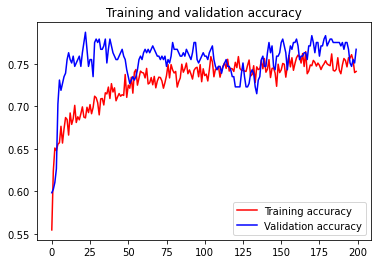

<Figure size 432x288 with 0 Axes>

In [11]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

In [12]:
model.load_weights("Best1.hdf5")
score = model.evaluate(X_val, Y_val ,verbose=1)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

8/8 [==============================] - 0s 24ms/step - loss: 0.4788 - accuracy: 0.7871
Test Loss: 0.478767454624176
Test accuracy: 0.7871485948562622


[0]


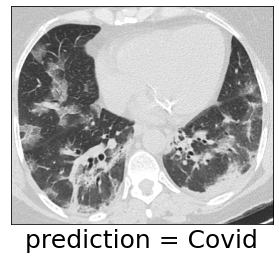

In [13]:
test_img=cv2.imread("../input/sarscov2-ctscan-dataset/COVID/Covid (10).png")
testimg_data_list=[]
test_img_resize=cv2.resize(test_img,(150,150))
testimg_data_list.append(test_img_resize)
testimg_data = np.array(testimg_data_list)
testimg_data = testimg_data.astype('float32')
testimg_data = testimg_data/255
testimg_data.shape

results = model.predict(testimg_data).argmax(axis=-1)
plt.imshow(test_img)
plt.gca().get_xaxis().set_ticks([])
plt.gca().get_yaxis().set_ticks([])
plt.xlabel('prediction = Covid', fontsize=25)
print(results)

[1]


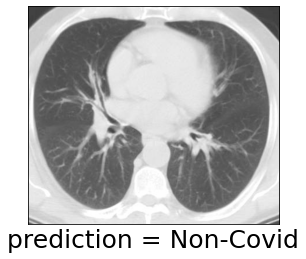

In [14]:
test_img=cv2.imread("../input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (100).png")
testimg_data_list=[]
test_img_resize=cv2.resize(test_img,(150,150))
testimg_data_list.append(test_img_resize)
testimg_data = np.array(testimg_data_list)
testimg_data = testimg_data.astype('float32')
testimg_data = testimg_data/255
testimg_data.shape

results = model.predict(testimg_data).argmax(axis=-1)
plt.imshow(test_img)
plt.gca().get_xaxis().set_ticks([])
plt.gca().get_yaxis().set_ticks([])
plt.xlabel('prediction = Non-Covid', fontsize=25)
print(results)